In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
from agent import DQN_agent
from memory import ReplayBuffer
import torch
import utils
import matplotlib.pyplot as plt
from IPython.display import  display
from env_wraped import make_env
%matplotlib inline

In [2]:
lr = 2e-3
num_iter = 1
num_episodes = 10000
warmup_episodes = 200
gamma = 0.99
epsilon = 1
target_update = 500
buffer_size = 100000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
seed = 123

In [3]:
env_name = "ALE/Breakout-v5"
render_mode="rgb_array"
env = make_env(env_name, render_mode)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
replay_buffer = ReplayBuffer(buffer_size)
state_channel = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQN_agent(state_channel, action_dim, gamma, lr,
            epsilon, target_update, device)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [ ]:
rewards_list = []
durations_list = []
epsilon_list = []
for i in range(num_iter):
    with tqdm(total=int(num_episodes / num_iter), desc='Iteration %d' % (i+1)) as pbar:
        for i_episode in range(int(num_episodes / num_iter)):
            episode_rewards = 0
            episode_durations = 0
            state, _ = env.reset()
            done = False
            
            if i_episode >= warmup_episodes:
                agent.decay_epsilon(i_episode, decay_rate=0.01)
            
            epsilon_list.append(agent.epsilon)    
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                replay_buffer.add(state, action, reward, next_state, done)
                
                state = next_state
                episode_rewards += reward
                episode_durations += 1
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': state_batch,
                        'actions': action_batch,
                        'next_states': next_state_batch,
                        'rewards': reward_batch,
                        'dones': done_batch
                    }
                    agent.update(transition_dict)

            rewards_list.append(episode_rewards)
            durations_list.append(episode_durations)
            if (i_episode + 1) % 100 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 100 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(rewards_list[-100:])
                })
            pbar.update(1)
print("complete the training of DQN agent!")

agent.save(f"./model/DQN_atari_agent.pth")

Iteration 1:  20%|█▉        | 1977/10000 [2:54:18<27:41:15, 12.42s/it, episode=1900, return=2.530]

In [7]:
agent.save(f"./model/DQN_atari_agent.pth")

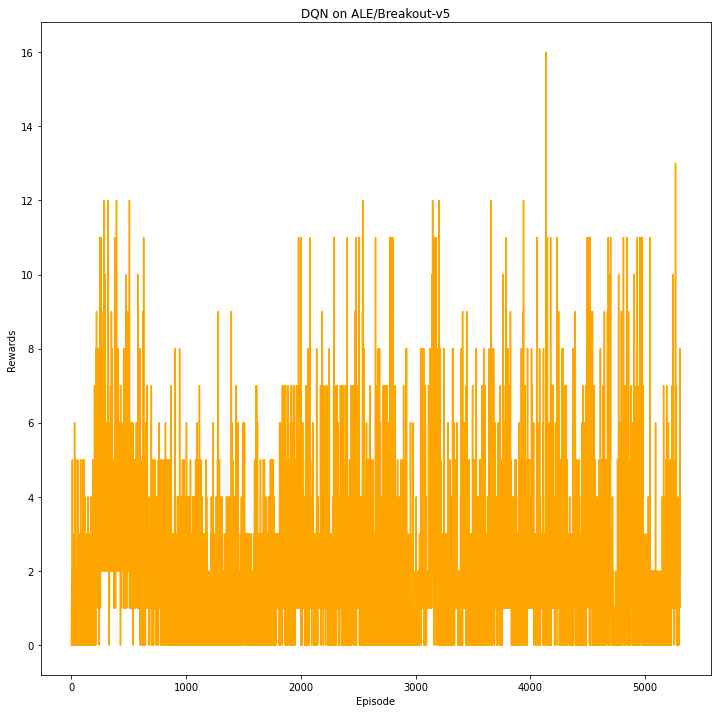

In [5]:
fig = plt.figure(1, figsize=(12, 12))

episodes_list = list(range(len(rewards_list)))
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(episodes_list, rewards_list, color='orange', label='Rewards')

plt.title('DQN on {}'.format(env_name))

plt.show()

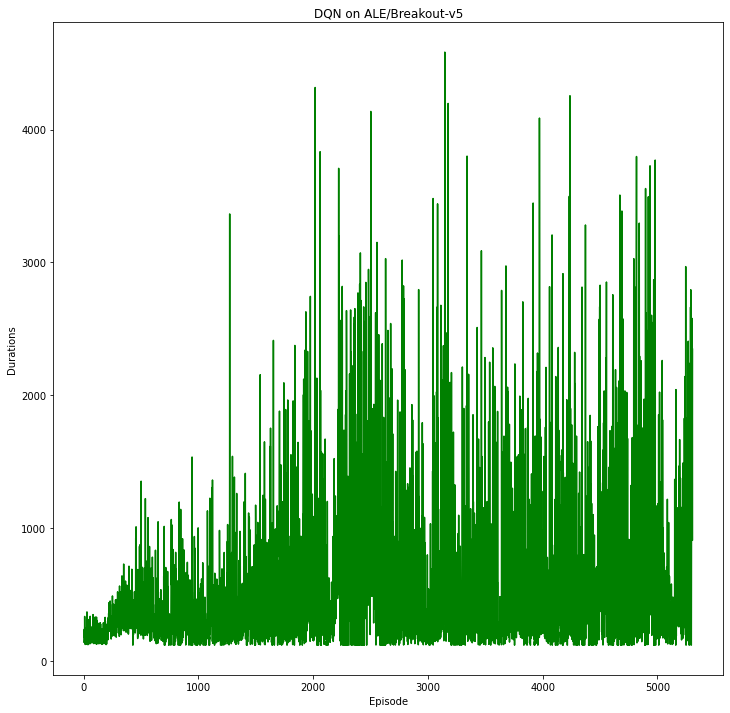

In [6]:
fig = plt.figure(1, figsize=(12, 12))

plt.xlabel('Episode')
plt.ylabel('Durations')
plt.plot(episodes_list, durations_list, color='green', label='Durations')

plt.title('DQN on {}'.format(env_name))

plt.show()

In [ ]:
for i in range(10):
    animation = agent.play(env, save_path='./animation/game_animation_%d.mp4' % (i + 1))

In [ ]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [ ]:
def show_state(env, step, reward):
    plt.figure(1)
    plt.clf()
    plt.imshow(env.render())
    plt.title("Step: %d, reward=%d" % (step, reward))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.pause(0.01)

In [ ]:
state, _ = env.reset()
encoded_state = utils.encode_state(state)
done = False
step = 0
rewards = 0
while not done:
    action = agent.take_action(encoded_state, mode='eval')
    next_state, reward, terminated, truncated, _ = env.step(action)
    show_state(env,step,reward)
    step += 1
    rewards += reward
    encoded_next_state = utils.encode_state(next_state)
    done = terminated or truncated

    state = next_state
    encoded_state = encoded_next_state
    
print('done!')
print(step)

env.close()